In [1]:
import os.path as op
from glob import glob
import gzip
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

from utils import plot_gradient, plot_subcortical_gradient, plot_meta_maps

In [2]:
def plot_profile(data_df, metric, hue_order, cmap="tab20"):
    sns.set(style="whitegrid")
    
    n_segments = 30
    for seg_sol in range(n_segments):
        fontsize=14
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(9 + seg_sol*0.2, 4)

        test_df = data_df[data_df["segment_solution"] == seg_sol + 3]
        test_df = test_df.reset_index()
        test_df["segment"] = test_df["segment"].astype(str)

        sns.lineplot(
            data=test_df,
            x="segment",
            y=metric,
            palette=cmap,
            hue="method",
            hue_order=hue_order,
            marker="o",
            ax=ax,
        )
        if seg_sol == 0:
            handles, labels = ax.get_legend_handles_labels()
            [ha.set_linewidth(8) for ha in handles ]
            new_labels = []
            for label in labels:
                method, dset_nm, seg = label.split("_")
                method = method.upper()
                seg = "PCT" if seg == "Percentile" else seg
                dset_nm = "NS" if dset_nm == "neurosynth" else "NQ"
                new_labels.append(f"{dset_nm}-{method}-{seg}")

        ax.get_legend().remove()

        text_lst = []
        mean_lst = []
        for approach in hue_order:
            approach_df = test_df[test_df["method"] == approach]
            # print(approach_df)
            mean_corr = approach_df[metric]
            text_lst.append(f"{mean_corr.mean():.3f} ± {mean_corr.std():.3f}")
            mean_lst.append(mean_corr.mean())

        ax_handles, ax_labels = ax.get_legend_handles_labels()
        sort_idx = np.argsort(-np.array(mean_lst))
        [ha.set_linewidth(6) for ha in ax_handles ]


        legend_title = "$Mean \pm \sigma$"
        ax.legend(
            np.array(ax_handles)[sort_idx],
            np.array(text_lst)[sort_idx],
            loc="upper left",
            bbox_to_anchor=(1.04, 1),
            ncol=2,
            title=legend_title,
            fontsize=fontsize,
        )
        
        ax.set_xlabel('Segment ID', fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        if metric == "max_corr":
            ax.set_ylabel('Max Correlation Coefficient', fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
            ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
            ax.set_yticklabels([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontsize=fontsize)
        elif metric == "information_content":
            ax.set_ylabel('Information Content', fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
            ax.set_yticks([2, 3, 4, 5, 6, 7, 8])
            ax.set_yticklabels([2, 3, 4, 5, 6, 7, 8], fontsize=fontsize)
        elif metric == "tfidf":
            ax.set_ylabel('TFIDF', fontsize=fontsize)

        fig.tight_layout()
        plt.savefig(op.join("./Fig", "performance", f"{metric}_profile_{seg_sol}.eps"), bbox_inches="tight")
        plt.show()
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)
    fig.legend(
        handles,
        new_labels,
        loc="center",
        ncol=9,
        fontsize=fontsize,
    )
    ax.axis('off')
    # bbox_to_anchor=(0.5, -0.01),
    fig.tight_layout()
    plt.savefig(op.join("./Fig", "performance", f"{metric}_profile_legend.eps"), bbox_inches="tight")
    plt.show()

In [3]:
def plot_mean_profile(data_df, metric, hue_order, cmap="tab20"):
    sns.set(style="white")
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(3, 15)

    sns.lineplot(
        data=data_df,
        x=metric,
        y="segment_solution",
        palette=cmap,
        hue="method",
        hue_order=hue_order,
        sort=False,
        marker="o",
        ax=ax,
        estimator=None,
    )
    ax.get_legend().remove()
    ax.spines[['right', "bottom"]].set_visible(False)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    if metric == "max_corr":
        fontsize = 12
        ax.set_xlabel('Mean Correlation Coefficient', fontsize=fontsize)
        ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
        ax.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5], fontsize=fontsize)
    elif metric == "ic":
        fontsize = 16
        ax.set_xlabel('Mean Information Content', fontsize=fontsize)
        ax.set_xticks([4, 5, 6, 7])
        ax.set_xticklabels([4, 5, 6, 7], fontsize=fontsize)
    elif metric == "tfidf":
        fontsize = 16
        ax.set_xlabel('Mean TFIDF', fontsize=fontsize)
        ax.set_xticks([0.05, 0.10, 0.15, 0.20])
        ax.set_xticklabels([0.05, 0.10, 0.15, 0.20], fontsize=fontsize)
    elif metric == "snr":
        fontsize = 12
        ax.set_xlabel('SNR', fontsize=fontsize)

    plt.xticks(fontsize=fontsize)
    ax.set_ylabel('Segment Solution', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    plt.savefig(op.join("./Fig", "performance", f"mean_{metric}_profile.eps"), bbox_inches="tight")
    plt.show()

In [4]:
result_dir = op.abspath("../results")
figure_dir = op.abspath("./Fig")

hue_order = [
    'term_neurosynth_Percentile',
    'term_neuroquery_Percentile',
    'term_neurosynth_KMeans', 
    "term_neuroquery_KMeans", 
    "term_neurosynth_KDE", 
    "term_neuroquery_KDE",
    'lda_neurosynth_Percentile',
    'lda_neuroquery_Percentile',
    'lda_neurosynth_KMeans', 
    "lda_neuroquery_KMeans", 
    "lda_neurosynth_KDE", 
    "lda_neuroquery_KDE",
    'gclda_neurosynth_Percentile',
    'gclda_neuroquery_Percentile',
    'gclda_neurosynth_KMeans', 
    "gclda_neuroquery_KMeans", 
    "gclda_neurosynth_KDE", 
    "gclda_neuroquery_KDE",
]

In [5]:
data_df = pd.read_csv(op.join(result_dir, "performance", "performance.tsv"),  delimiter="\t")
data_df

Unnamed: 0                      method  segment  segment_solution  \
0              0  term_neurosynth_Percentile        1                 3   
1              1  term_neurosynth_Percentile        2                 3   
2              2  term_neurosynth_Percentile        3                 3   
3              3  term_neurosynth_Percentile        1                 4   
4              4  term_neurosynth_Percentile        2                 4   
...          ...                         ...      ...               ...   
9445        9445        gclda_neuroquery_KDE       28                32   
9446        9446        gclda_neuroquery_KDE       29                32   
9447        9447        gclda_neuroquery_KDE       30                32   
9448        9448        gclda_neuroquery_KDE       31                32   
9449        9449        gclda_neuroquery_KDE       32                32   

      max_corr    pvalue  corr_idx                    features  \
0     0.753732  0.000000      2632         sensorimotor cortex   
1     0.222636  0.000240      2218          posterior inferior   
2     0.415830  0.000000      2537                   retrieval   
3     0.746558  0.000000      2632         sensorimotor cortex   
4     0.382924  0.000000      1827                       modal   
...        ...       ...       ...                         ...   
9445  0.036603  0.000948        40    41_item_retrieval_effect   
9446  0.032380  0.000211        40    41_item_retrieval_effect   
9447  0.059686  0.001557        40    41_item_retrieval_effect   
9448  0.114617  0.003717       145   146_patient_group_control   
9449  0.080108  0.015188       147  148_event_region_retrieval   

      information_content     tfidf classification  
0                4.500788  0.112603     Anatomical  
1                4.601763  0.103167     Anatomical  
2                3.958023  0.151619     Functional  
3                4.500788  0.112603     Anatomical  
4                4.344219  0.134611   Non-Specific  
...                   ...       ...            ...  
9445             5.607083  0.024840   Non-Specific  
9446             5.607083  0.024840   Non-Specific  
9447             5.607083  0.024840   Non-Specific  
9448             4.956624  0.025590       Clinical  
9449             5.461466  0.027224   Non-Specific  

[9450 rows x 11 columns]

In [6]:
mean_data_df = pd.read_csv(op.join(result_dir, "performance", "mean_performance.tsv"),  delimiter="\t")
mean_data_df["segment_solution"] = mean_data_df["segment_solution"].astype(str)
mean_data_df

Unnamed: 0                      method segment_solution  max_corr  \
0             0  term_neurosynth_Percentile                3  0.464066   
1             1  term_neurosynth_Percentile                4  0.453695   
2             2  term_neurosynth_Percentile                5  0.393532   
3             3  term_neurosynth_Percentile                6  0.360578   
4             4  term_neurosynth_Percentile                7  0.338433   
..          ...                         ...              ...       ...   
535         535        gclda_neuroquery_KDE               28  0.063104   
536         536        gclda_neuroquery_KDE               29  0.061431   
537         537        gclda_neuroquery_KDE               30  0.059433   
538         538        gclda_neuroquery_KDE               31  0.060819   
539         539        gclda_neuroquery_KDE               32  0.060708   

           ic     tfidf       snr  
0    4.353525  0.122463  0.333333  
1    4.479368  0.101566  0.250000  
2    4.409586  0.089423  0.200000  
3    4.362325  0.113641  0.500000  
4    4.481374  0.104771  0.285714  
..        ...       ...       ...  
535  5.227557  0.037512  0.285714  
536  5.185692  0.037073  0.275862  
537  5.207922  0.037464  0.266667  
538  5.219846  0.039925  0.290323  
539  5.236689  0.040447  0.343750  

[540 rows x 7 columns]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


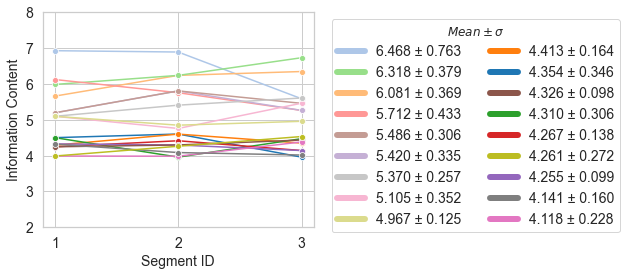

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


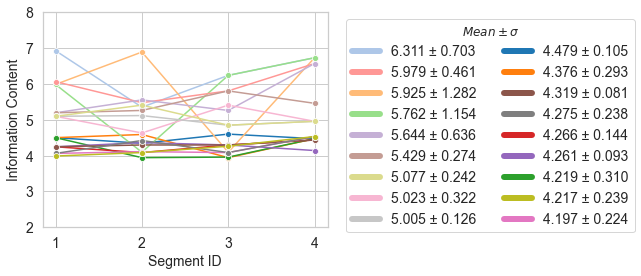

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


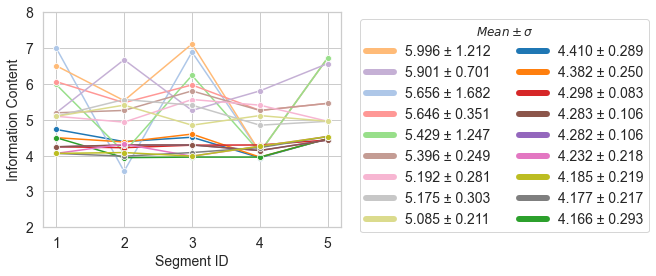

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


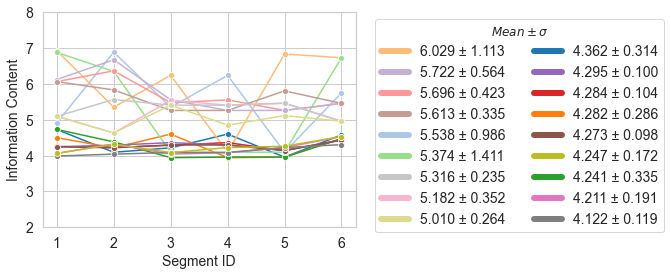

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


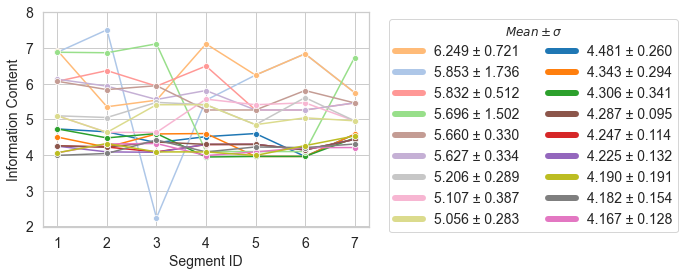

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


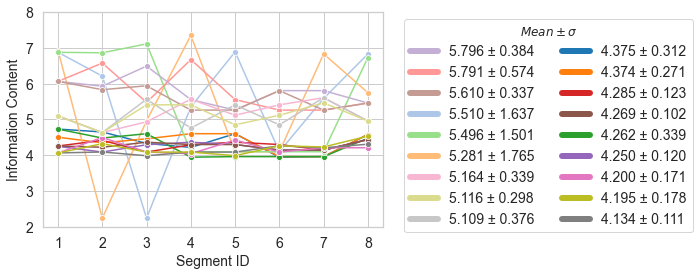

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


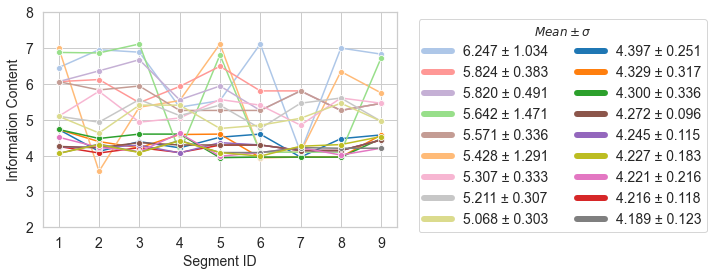

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


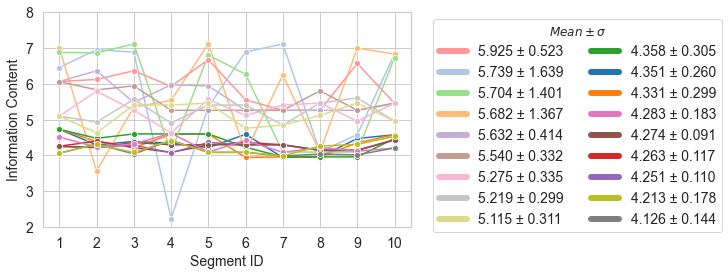

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


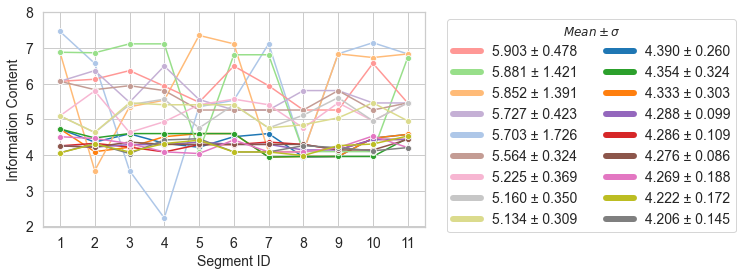

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


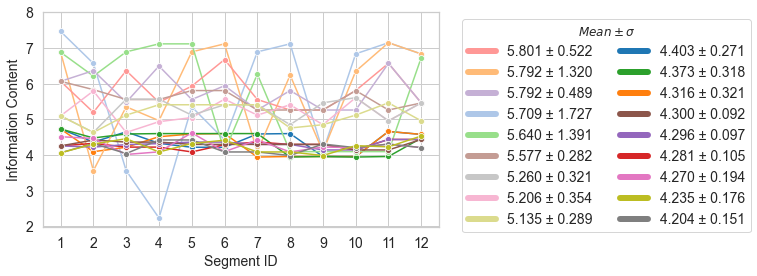

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


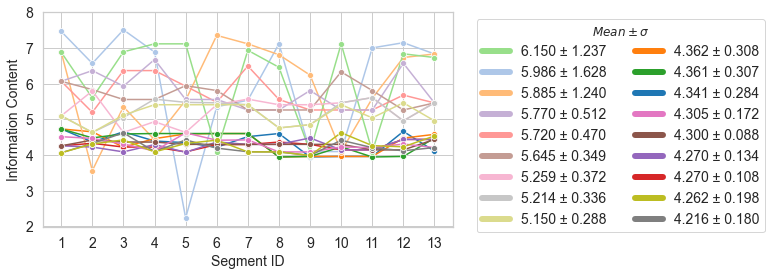

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


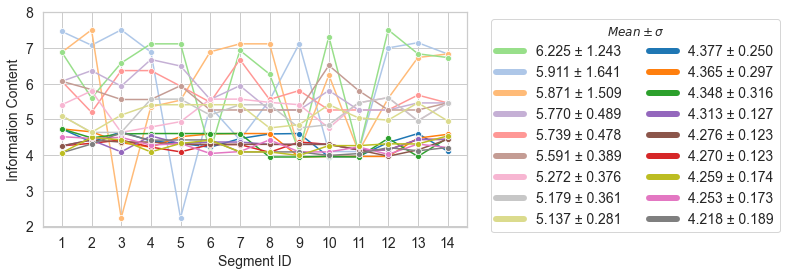

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


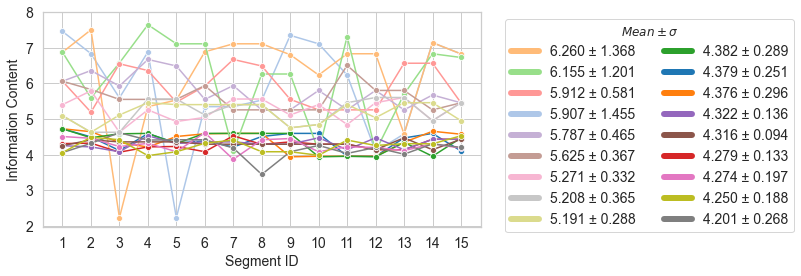

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


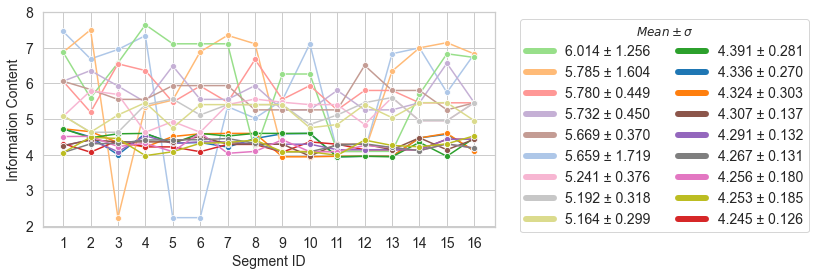

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


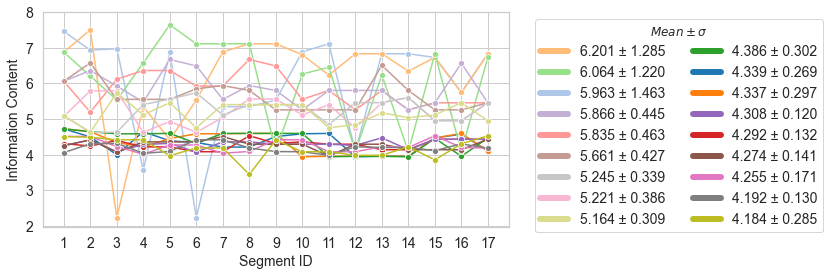

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


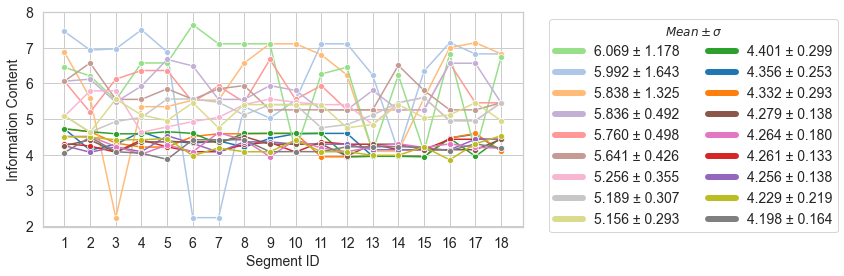

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


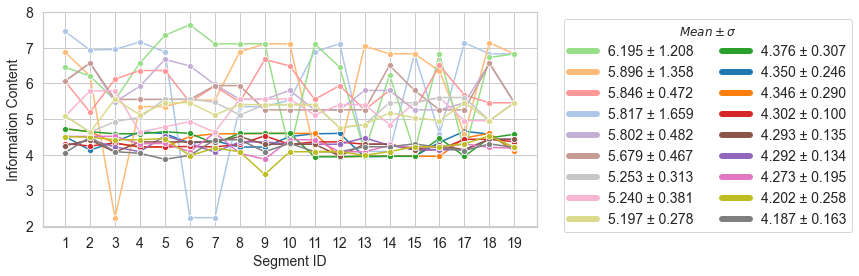

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


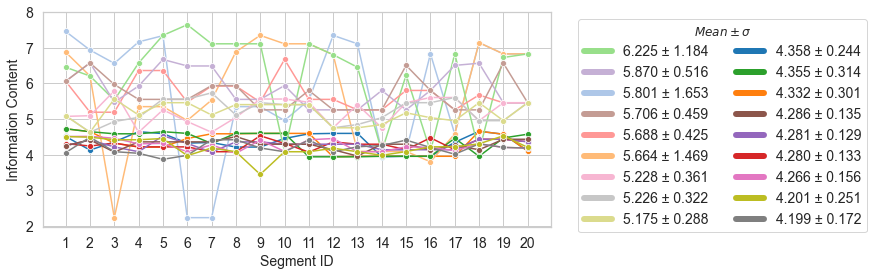

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


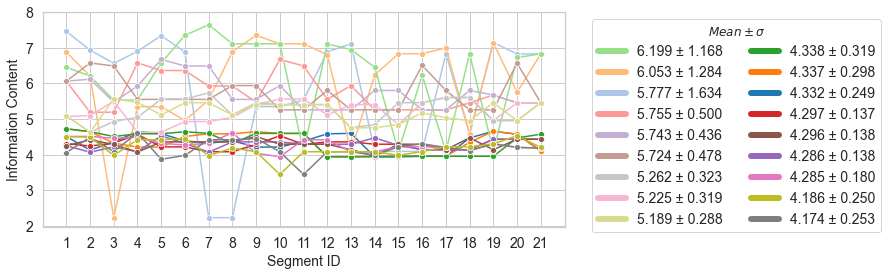

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


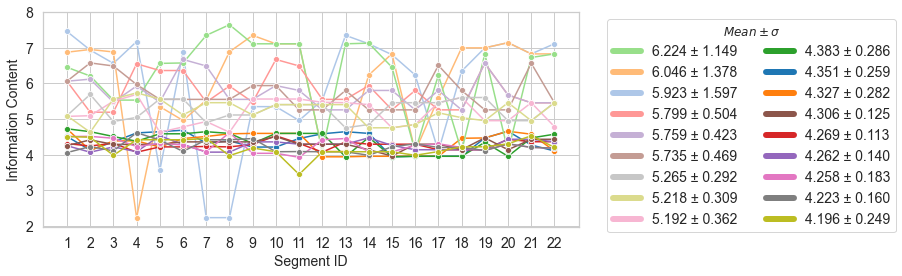

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


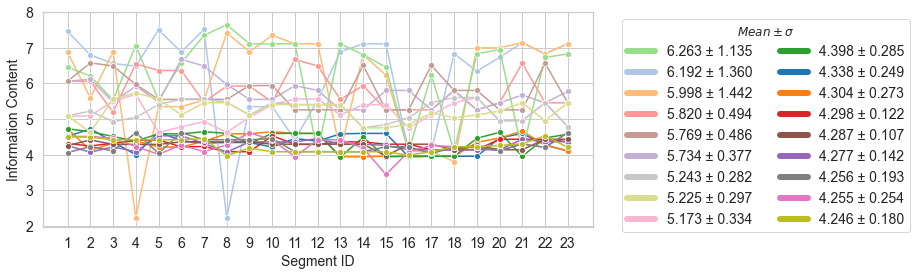

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


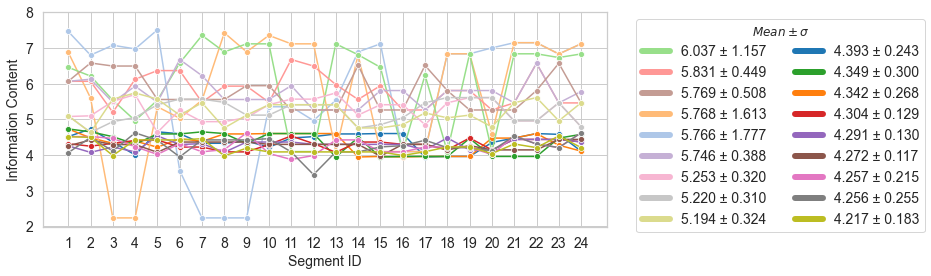

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


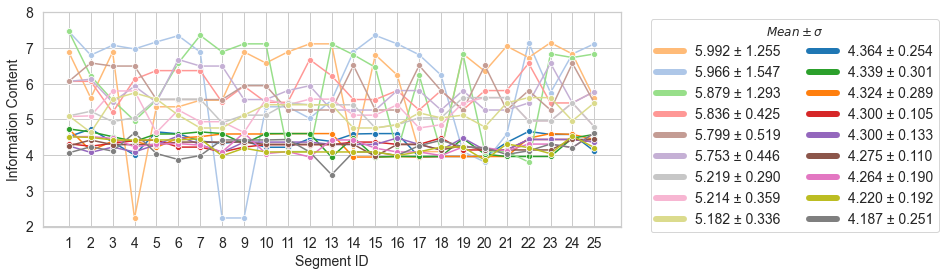

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


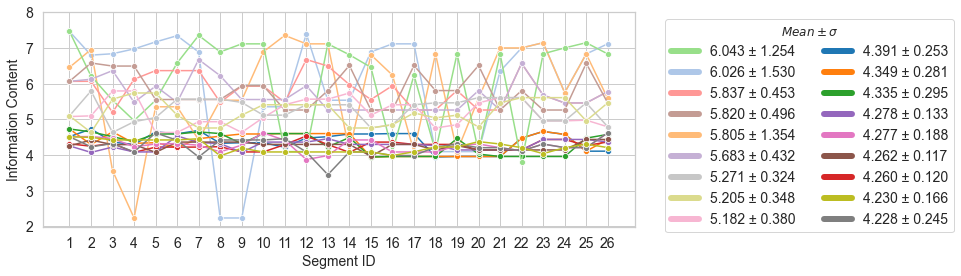

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


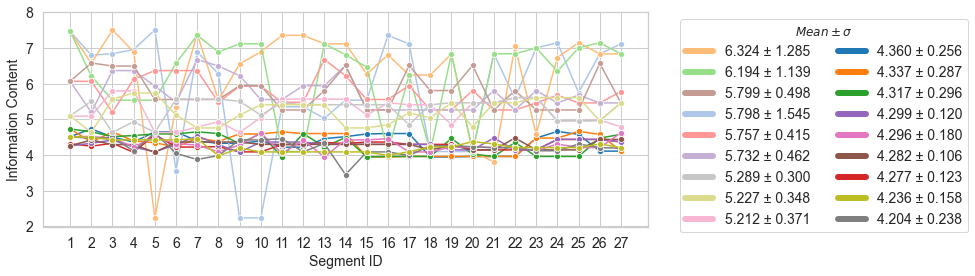

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


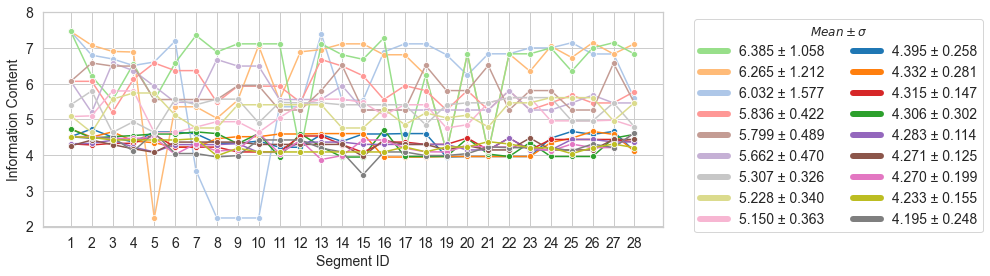

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


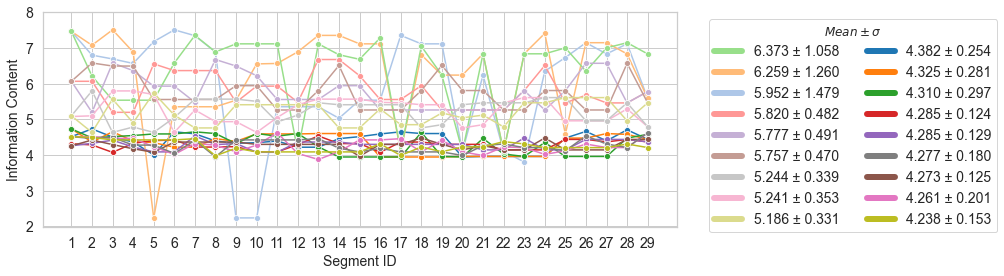

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


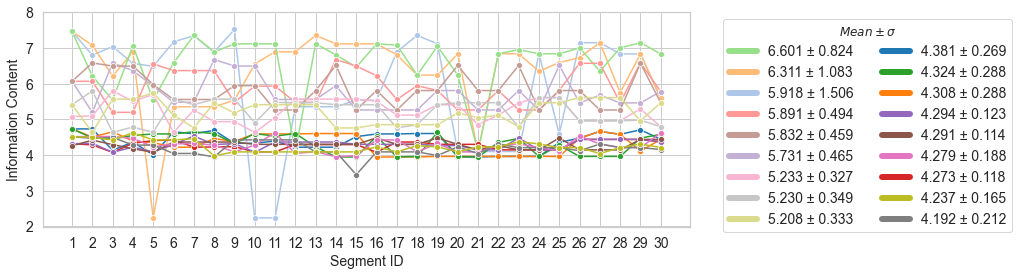

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


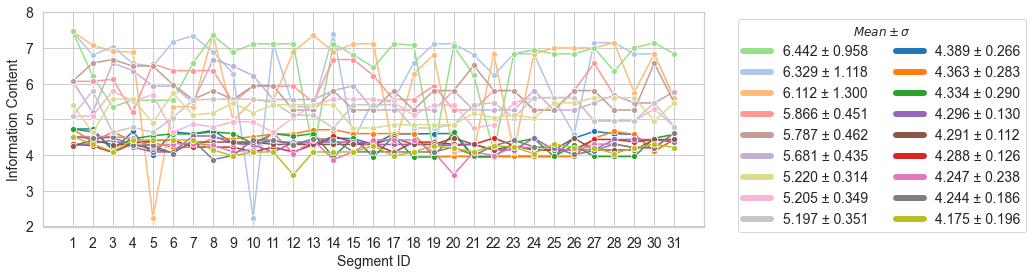

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


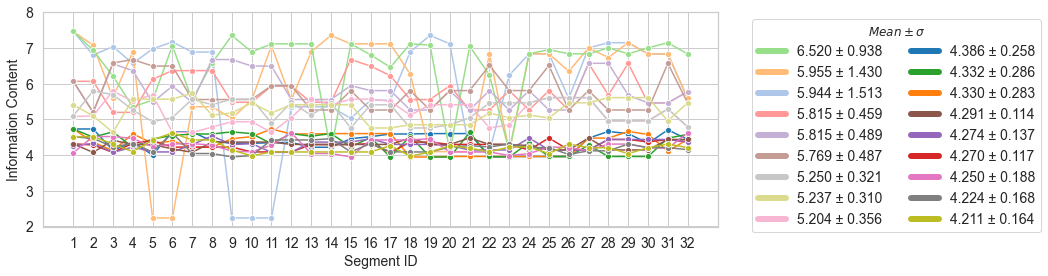

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


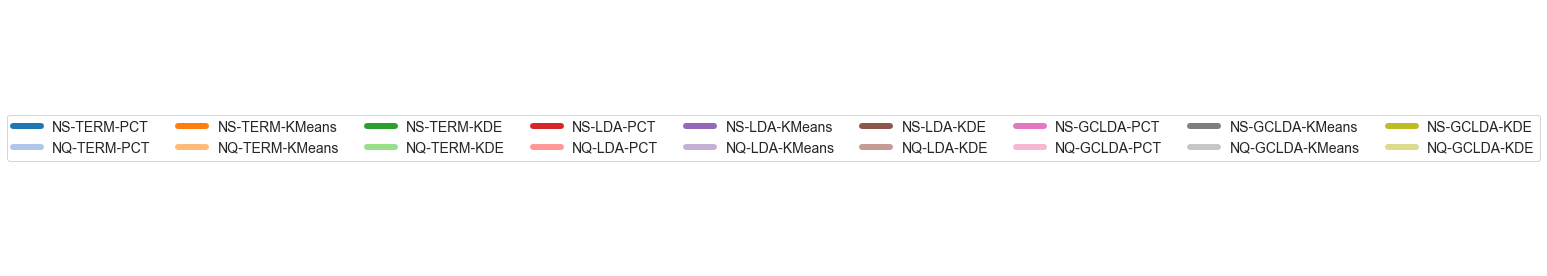

In [27]:
# ["max_corr", "information_content", "tfidf"]
for metric in ["information_content"]:
    plot_profile(data_df, metric, hue_order)

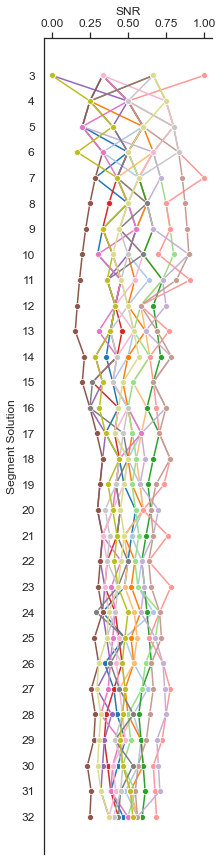

In [23]:
# ["max_corr", "ic", "tfidf", "snr"]
for metric in ["snr"]:
    plot_mean_profile(mean_data_df, metric, hue_order)

In [8]:
sub_mean_data_df = mean_data_df.pivot_table(
    values="snr", index=mean_data_df["segment_solution"], columns="method"
)
sub_mean_data_df = sub_mean_data_df.reindex(hue_order, axis=1)
sub_mean_data_df.index = sub_mean_data_df.index.astype(int)
sub_mean_data_df = sub_mean_data_df.sort_index()
sub_mean_data_df.index = sub_mean_data_df.index.astype(str)
sub_mean_data_df

method            term_neurosynth_Percentile  term_neuroquery_Percentile  \
segment_solution                                                           
3                                   0.333333                    0.333333   
4                                   0.250000                    0.500000   
5                                   0.200000                    0.600000   
6                                   0.500000                    0.333333   
7                                   0.285714                    0.571429   
8                                   0.500000                    0.625000   
9                                   0.333333                    0.555556   
10                                  0.300000                    0.500000   
11                                  0.454545                    0.636364   
12                                  0.416667                    0.500000   
13                                  0.384615                    0.538462   
14                                  0.357143                    0.500000   
15                                  0.400000                    0.400000   
16                                  0.437500                    0.500000   
17                                  0.352941                    0.588235   
18                                  0.444444                    0.500000   
19                                  0.473684                    0.578947   
20                                  0.550000                    0.600000   
21                                  0.523810                    0.523810   
22                                  0.500000                    0.590909   
23                                  0.478261                    0.565217   
24                                  0.333333                    0.666667   
25                                  0.480000                    0.480000   
26                                  0.346154                    0.538462   
27                                  0.407407                    0.629630   
28                                  0.428571                    0.535714   
29                                  0.482759                    0.586207   
30                                  0.433333                    0.566667   
31                                  0.387097                    0.483871   
32                                  0.468750                    0.562500   

method            term_neurosynth_KMeans  term_neuroquery_KMeans  \
segment_solution                                                   
3                               0.666667                0.666667   
4                               0.250000                0.750000   
5                               0.600000                0.800000   
6                               0.666667                0.666667   
7                               0.571429                0.428571   
8                               0.625000                0.625000   
9                               0.555556                0.666667   
10                              0.500000                0.600000   
11                              0.545455                0.727273   
12                              0.500000                0.583333   
13                              0.615385                0.615385   
14                              0.500000                0.642857   
15                              0.466667                0.533333   
16                              0.500000                0.625000   
17                              0.529412                0.588235   
18                              0.500000                0.555556   
19                              0.526316                0.578947   
20                              0.600000                0.600000   
21                              0.476190                0.476190   
22                              0.545455                0.500000   
23                              0.521739                0.478261   
24 

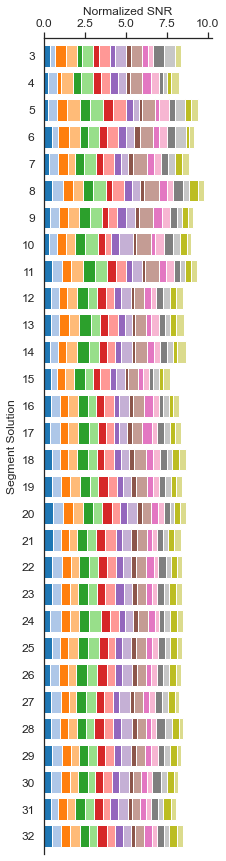

In [9]:
sns.set(style="white")

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 15)

my_cmap = plt.get_cmap("tab20")
sub_mean_data_df.plot.barh(
    rot=0,
    width=.81,
    stacked=True,
    color=my_cmap.colors[: len(hue_order)],
    ax=ax,
)
plt.gca().invert_yaxis()
ax.get_legend().remove()
ax.spines[['right', "bottom"]].set_visible(False)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

fontsize = 12
ax.set_xlabel('Normalized SNR', fontsize=fontsize)

plt.xticks(fontsize=fontsize)
ax.set_ylabel('Segment Solution', fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.savefig(op.join("./Fig", "performance", "mean_snr_barh.eps"), bbox_inches="tight")
plt.show()


/Users/jperaza/Documents/envs/gradec_env/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


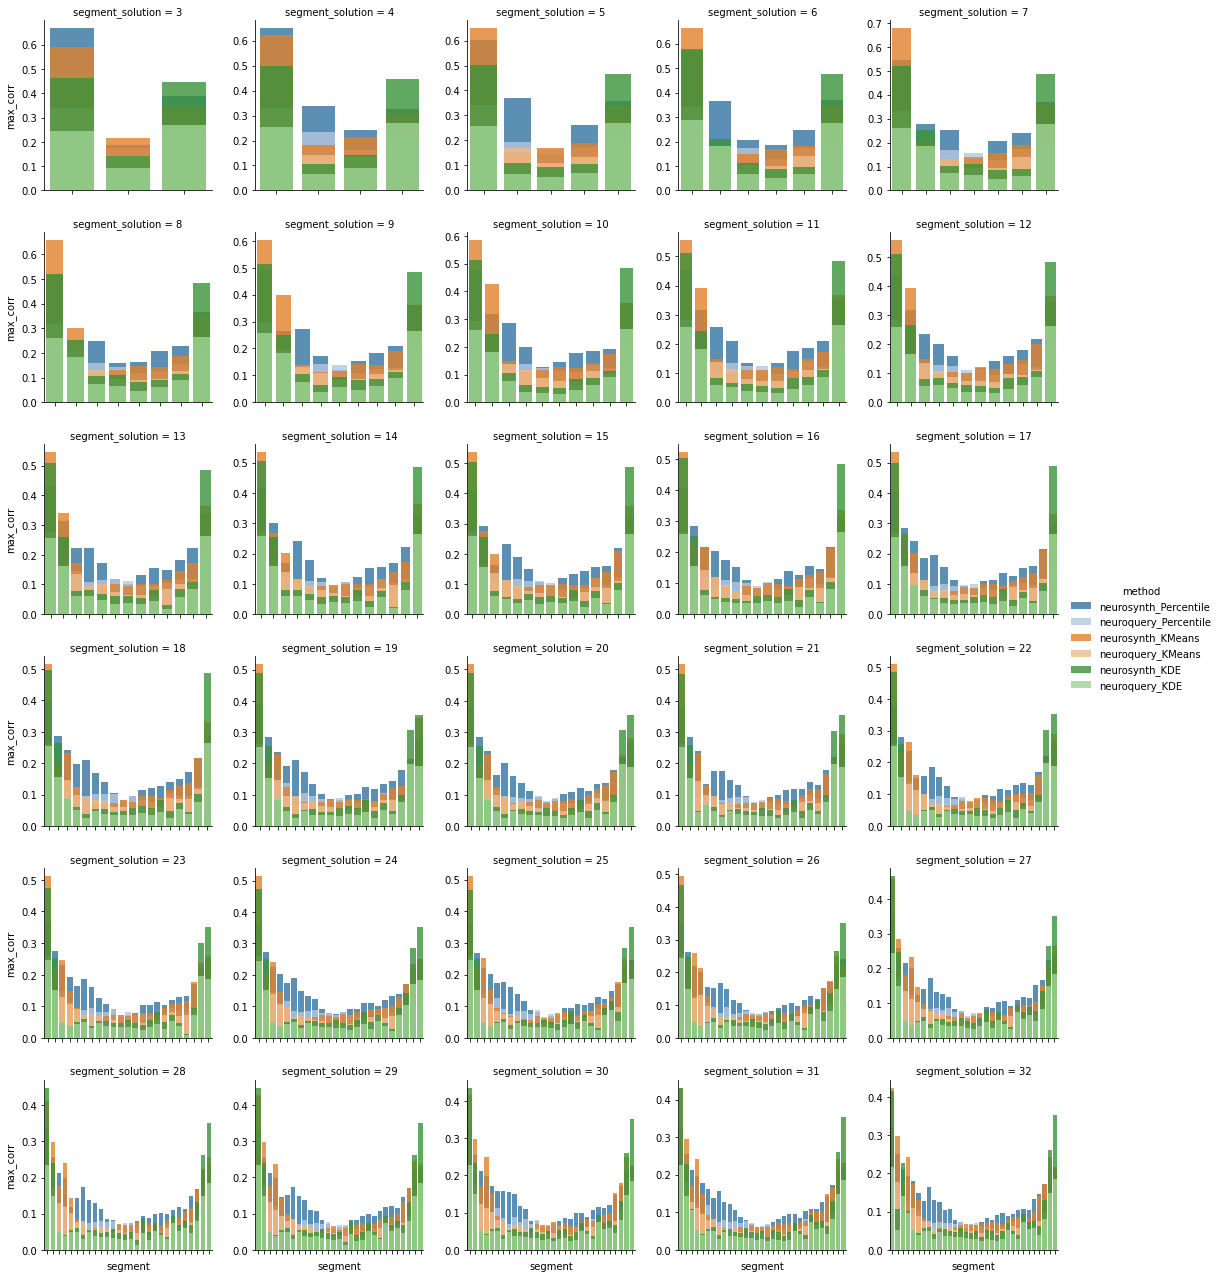

In [19]:
# lineplot, , marker='o'
segm = data_df.segment_solution.unique()
g = sns.FacetGrid(data_df, col="segment_solution", palette=cmap, hue="method", hue_order=hue_order, sharex=False, sharey=False, col_wrap=5)
g.map(sns.barplot, "segment", "max_corr", alpha=.8)
g.add_legend()
g.set(xticklabels=[])
plt.show()

In [ ]:
fslr_path = op.join(result_dir, "gradient_decoding", "lda_neurosynth_fslr")
kmeans_grad_seg_path = op.join(result_dir, "gradient_segmentation", "kmeans")

fslr_lh_fnames = sorted(glob(op.join(fslr_path, "*hemi-L_feature.func.gii")))
fslr_rh_fnames = sorted(glob(op.join(fslr_path, "*hemi-R_feature.func.gii")))

kmeans_grad_seg_lh_fnames = sorted(glob(op.join(kmeans_grad_seg_path, "*KMeans03_desc-Bin*hemi-L_feature.func.gii")))
kmeans_grad_seg_rh_fnames = sorted(glob(op.join(kmeans_grad_seg_path, "*KMeans03_desc-Bin*hemi-R_feature.func.gii")))

/Users/jperaza/Documents/envs/gradec_env/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


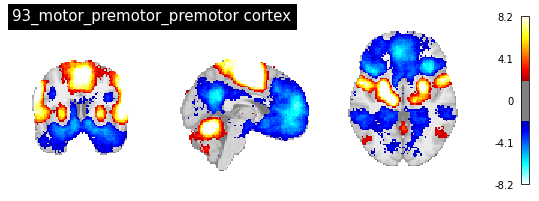

In [7]:
plot_meta_maps(lda_based_ns_decoder_fn, n_init=92, n_maps=1, threshold=2, model="decoder")

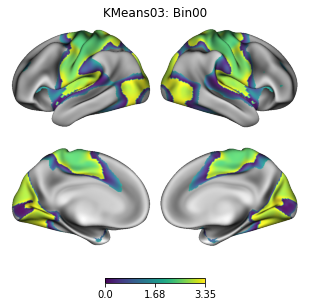

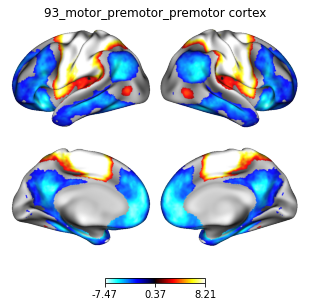

In [33]:

gclda_grad_fnames = zip([fslr_lh_fnames[92]], [fslr_rh_fnames[92]])
features_to_plot = [features[92]]

kmeans_grad_seg_fnames = zip([kmeans_grad_seg_lh_fnames[0]], [kmeans_grad_seg_rh_fnames[0]])

plot_gradient("../data", kmeans_grad_seg_fnames)

plot_gradient("../data", gclda_grad_fnames, features_to_plot, threshold_=2, cmap=cmap)